In [232]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from google.colab import drive

## Load dataset

In [233]:

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/GerminationDatabaseFile.csv', encoding='latin-1')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [234]:
df.head()

,Unnamed: 0,id_test,accepted_binomial,EUNIS_name,original_name,contributor_name,contributor_email,Cocontributors,collection_year,doi,...,scarification,stratification,other_treatments,water_potential,photoperiod,light_quality,T_day,T_night,seeds_sown,seeds_germinated
0,1,3124,Brachypodium retusum,Brachypodium retusum,Brachypodium retusum,"Cruz-Tejada, Diana M.",diana.cruztejada@phd.unipi.it,"Carta, Angelino",2016,10.1002/ajb2.1116,...,none,none,none,0.0,12,white,20.0,15.0,160,123
1,2,3127,Brachypodium retusum,Brachypodium retusum,Brachypodium retusum,"Cruz-Tejada, Diana M.",diana.cruztejada@phd.unipi.it,"Carta, Angelino",2016,10.1002/ajb2.1116,...,none,none,none,0.0,12,white,20.0,15.0,160,77
2,3,3117,Brachypodium retusum,Brachypodium retusum,Brachypodium retusum,"Cruz-Tejada, Diana M.",diana.cruztejada@phd.unipi.it,"Carta, Angelino",2016,10.1002/ajb2.1116,...,none,none,none,0.0,12,white,20.0,15.0,160,41
3,4,3119,Brachypodium retusum,Brachypodium retusum,Brachypodium retusum,"Cruz-Tejada, Diana M.",diana.cruztejada@phd.unipi.it,"Carta, Angelino",2016,10.1002/ajb2.1116,...,none,none,none,0.0,12,white,20.0,15.0,160,17
4,5,3125,Brachypodium retusum,Brachypodium retusum,Brachypodium retusum,"Cruz-Tejada, Diana M.",diana.cruztejada@phd.unipi.it,"Carta, Angelino",2016,10.1002/ajb2.1116,...,none,none,none,0.0,12,white,20.0,15.0,160,101


In [235]:
df.columns

Index(['Unnamed: 0', 'id_test', 'accepted_binomial', 'EUNIS_name',
       'original_name', 'contributor_name', 'contributor_email',
       'Cocontributors', 'collection_year', 'doi', 'collection_site',
       'collection_country', 'iso_code', 'latitude', 'longitude',
       'coordinate_accuracy', 'storage', 'substrate', 'experiment_length',
       'scarification', 'stratification', 'other_treatments',
       'water_potential', 'photoperiod', 'light_quality', 'T_day', 'T_night',
       'seeds_sown', 'seeds_germinated'],
      dtype='object')

##Drop Unnecessary Columns

In [236]:
drop_cols = [
    "Unnamed: 0", "id_test", "contributor_name", "contributor_email",
    "Cocontributors", "doi", "original_name", "EUNIS_name",
    "collection_site", "collection_country", "iso_code", "collection_year", "experiment_length",
    "latitude", "coordinate_accuracy", "longitude" # IDs, metadata, and redundant info
]

df = df.drop(columns=drop_cols)

## Calculate and create 'germination rate' column




In [237]:
df["germination_rate"] = df["seeds_germinated"] / df["seeds_sown"]


##Drop more unncessary columns after calculating the germination rate

In [238]:
df = df.drop(columns=["seeds_sown", "seeds_germinated"])

##Check for missing values

In [239]:
df.isnull().sum()

,0
accepted_binomial,0
storage,0
substrate,0
scarification,0
stratification,0
other_treatments,0
water_potential,0
photoperiod,0
light_quality,0
T_day,0


##Statistical summary

In [240]:
df.describe()

,water_potential,T_day,T_night,germination_rate
count,4680.000000,4680.000000,4680.000000,4680.000000
mean,-0.046503,20.029395,17.198006,0.445037
std,0.235907,5.482521,5.867381,0.360365
min,-3.900000,3.000000,3.000000,0.000000
25%,0.000000,18.000000,15.000000,0.080000
50%,0.000000,20.000000,20.000000,0.400000
75%,0.000000,24.000000,20.000000,0.820000
max,0.000000,40.000000,40.000000,1.000000


##Datatype of the columns

In [241]:
df.dtypes

,0
accepted_binomial,object
storage,object
substrate,object
scarification,object
stratification,object
other_treatments,object
water_potential,float64
photoperiod,object
light_quality,object
T_day,float64


##EDA

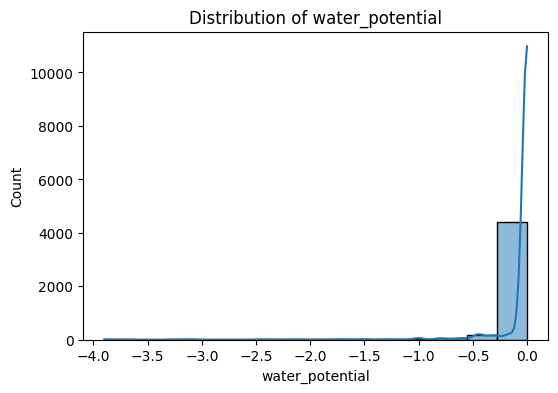

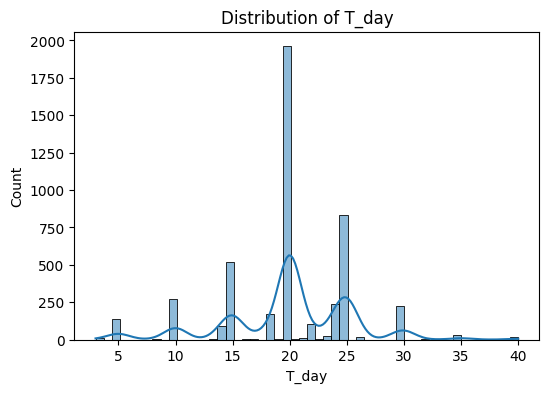

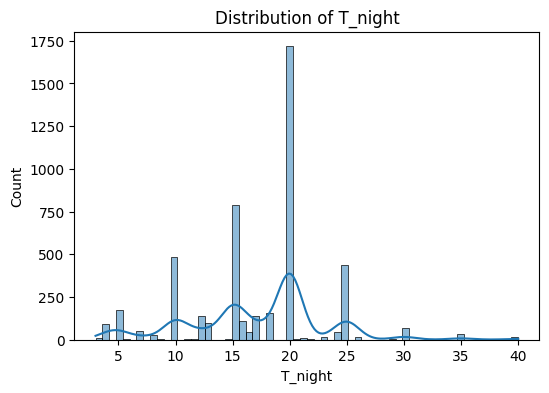

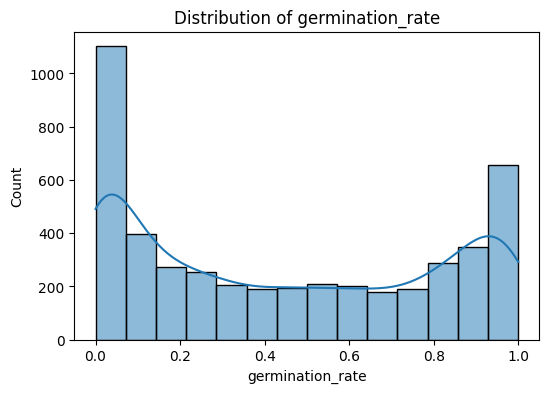

In [242]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


##One hot encoding

In [243]:
categorical_cols = ["accepted_binomial", "storage", "substrate",
                    "scarification", "stratification", "other_treatments",
                    "photoperiod", "light_quality"]

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [244]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4680 entries, 0 to 4679
Columns: 995 entries, water_potential to light_quality_white fluorescent tube (40-50 lmol m2s-1)
dtypes: bool(991), float64(4)
memory usage: 4.6 MB


## Set target variable

In [245]:
y = df["germination_rate"]

### Separate and keep only input features

In [246]:
X = df.drop(columns=["germination_rate"])

##Train and test split

In [247]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [248]:
df.isnull().sum()

,0
water_potential,0
T_day,0
T_night,0
germination_rate,0
accepted_binomial_Achillea millefolium,0
...,...
light_quality_fluorescent,0
light_quality_none,0
light_quality_white,0
light_quality_white fluorescent tube (40-50 lmol m-2s-1),0


##Model Training: Linear Regression




In [249]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

##Prediction with the linear regression model


In [250]:
y_pred = lr_model.predict(X_test)

##Evaluation metrices for the linear regression model

In [251]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Median Absolute Error (MedAE):", medae)
print("R² Score:", r2)


Mean Squared Error (MSE): 0.06090543470847941
Root Mean Squared Error (RMSE): 0.24679026461446854
Mean Absolute Error (MAE): 0.16690335079437096
Median Absolute Error (MedAE): 0.10649881983986009
R² Score: 0.5312472947222864


##Model Training: Random Forest


In [252]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

##Prediction with the random forest model

In [253]:
y_pred = rf_model.predict(X_test)

##Evaluation metrices for the random forest model

In [254]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # compute RMSE manually
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RandomForest Regression Metrics:")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("MedAE:", medae)
print("R²:", r2)

RandomForest Regression Metrics:
MSE: 0.034263996548015874
RMSE: 0.18510536607028946
MAE: 0.12748478542886355
MedAE: 0.079561037203538
R²: 0.7362905108158997
